In [1]:
import polars as pl
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [4]:
data = pd.read_parquet('Data/model/store_CA_1_data.parquet')
data.tail()

,sales_id,date_id,item_id,store_id,units_sold,revenue,dept_id,cat_id,item_name,price,...,day_of_month,day_name,month,year,week_id,event_name,event_type,snap_CA,snap_TX,snap_WI
5832732,9912289,2011-12-20,FOODS_3_817,CA_1,0,0.00,FOODS_3,FOODS,FOODS_3_817,2.82,...,d_326,Thursday,12,2011,11147,No Event,No Event,0,0,0
5832733,9912290,2011-12-20,FOODS_3_818,CA_1,0,0.00,FOODS_3,FOODS,FOODS_3_818,2.98,...,d_326,Thursday,12,2011,11147,No Event,No Event,0,0,0
5832734,9912291,2011-12-20,FOODS_3_819,CA_1,3,6.06,FOODS_3,FOODS,FOODS_3_819,1.98,...,d_326,Thursday,12,2011,11147,No Event,No Event,0,0,0
5832735,9912292,2011-12-20,FOODS_3_820,CA_1,2,3.94,FOODS_3,FOODS,FOODS_3_820,1.97,...,d_326,Thursday,12,2011,11147,No Event,No Event,0,0,0
5832736,9912297,2011-12-20,FOODS_3_825,CA_1,0,0.00,FOODS_3,FOODS,FOODS_3_825,4.11,...,d_326,Thursday,12,2011,11147,No Event,No Event,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832737 entries, 0 to 5832736
Data columns (total 27 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sales_id      int64  
 1   date_id       object 
 2   item_id       object 
 3   store_id      object 
 4   units_sold    int64  
 5   revenue       float64
 6   dept_id       object 
 7   cat_id        object 
 8   item_name     object 
 9   price         float64
 10  store_name    object 
 11  store_type    object 
 12  store_size    int64  
 13  state_id      object 
 14  state_name    object 
 15  region        object 
 16  weekday       object 
 17  day_of_month  object 
 18  day_name      object 
 19  month         int64  
 20  year          int64  
 21  week_id       int64  
 22  event_name    object 
 23  event_type    object 
 24  snap_CA       int64  
 25  snap_TX       int64  
 26  snap_WI       int64  
dtypes: float64(2), int64(9), object(16)
memory usage: 1.2+ GB


In [3]:
# --- Downcast numerical types
for c in data.select_dtypes(include=['int64']).columns:
    data[c] = pd.to_numeric(data[c], downcast='integer')

for c in data.select_dtypes(include=['float64']).columns:
    data[c] = pd.to_numeric(data[c], downcast='float')

# --- Check high-cardinality columns before converting str -> category
object_cols = data.select_dtypes(include=['object']).columns
high_cardinality = []
safe_cats = []

for c in object_cols:
    nunique = data[c].nunique()
    ratio = nunique / len(data)
    if ratio > 0.1:  # hơn 10% giá trị unique → thường không nên category
        high_cardinality.append(c)
    else:
        safe_cats.append(c)

# --- Chuyển các cột categorical hợp lý
for c in safe_cats:
    data[c] = data[c].astype('category')

drop_cols = ['revenue', "store_name", "state_name","region","store_id","item_name","item_id","price","week_id"]
# --- Gợi ý drop ban đầu (chưa chắc đúng về mặt mô hình)
data.drop(columns=drop_cols, inplace=True)


In [4]:
data.head()

,sales_id,date_id,units_sold,dept_id,cat_id,store_type,store_size,state_id,weekday,day_of_month,day_name,month,year,event_name,event_type,snap_CA,snap_TX,snap_WI
0,14787653,2012-05-28,0,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_486,Wednesday,5,2012,MemorialDay,National,0,0,0
1,14787671,2012-05-28,0,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_486,Wednesday,5,2012,MemorialDay,National,0,0,0
2,14787673,2012-05-28,3,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_486,Wednesday,5,2012,MemorialDay,National,0,0,0
3,14787698,2012-05-28,6,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_486,Wednesday,5,2012,MemorialDay,National,0,0,0
4,14787705,2012-05-28,0,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_486,Wednesday,5,2012,MemorialDay,National,0,0,0


In [5]:
# Tổng hợp dữ liệu theo week id cho mô hình ÂRIMA/SARIMA
agg_dict = {col: 'first' for col in data.columns if col != 'date_id'}
agg_dict['units_sold'] = 'sum'
data_daily = data.groupby('date_id').agg(agg_dict).reset_index()


┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ FutureWarning in                                                            │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_21372\1916280193.py:4           │
│ The default of observed=False is deprecated and will be changed to True in  │
│ a future version of pandas. Pass observed=False to retain current behavior  │
│ or observed=True to adopt the future default and silence this warning.      │
└─────────────────────────────────────────────────────────────────────────────┘


<Axes: title={'center': 'Units Sold Over Time'}, xlabel='date_id'>

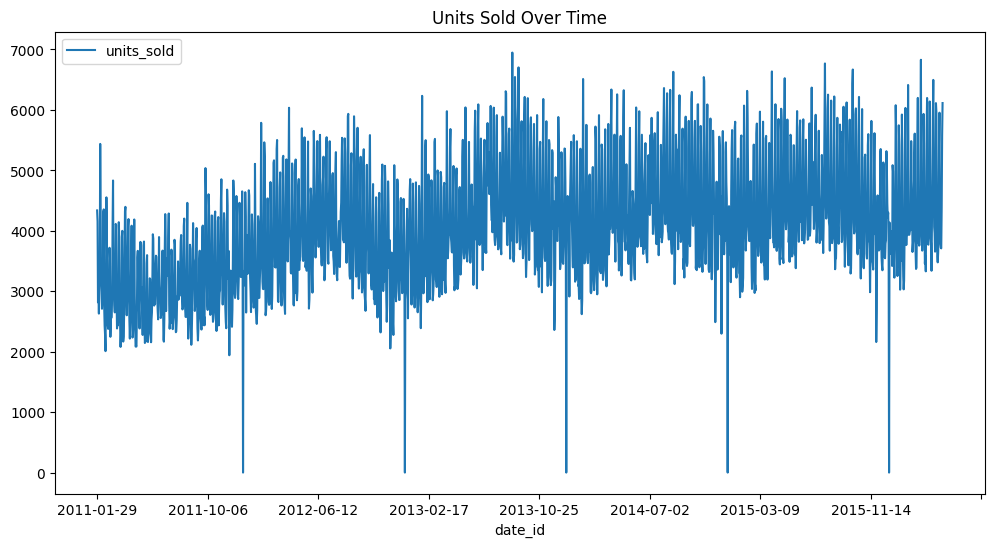

In [6]:
data_daily.plot(x='date_id', y='units_sold', figsize=(12,6), title='Units Sold Over Time')

In [7]:
# Tính trung bình trượt và độ lệch chuẩn trượt (cửa sổ 7 ngày)
rolling_mean = data_daily['units_sold'].rolling(window=7, center=True).mean()
rolling_std = data_daily['units_sold'].rolling(window=7, center=True).std()

# Xác định outlier là những điểm lệch quá 3 lần độ lệch chuẩn so với hàng xóm
is_outlier = (data_daily['units_sold'] > rolling_mean + 3 * rolling_std)

# Thay thế outlier bằng giá trị rolling mean của nó (hoặc np.nan rồi interpolate)
data_daily.loc[is_outlier, 'units_sold'] = rolling_mean[is_outlier]

In [8]:
data_daily.head()

,date_id,sales_id,units_sold,dept_id,cat_id,store_type,store_size,state_id,weekday,day_of_month,day_name,month,year,event_name,event_type,snap_CA,snap_TX,snap_WI
0,2011-01-29,5,4337,HOBBIES_1,HOBBIES,regular,10008,CA,Saturday,d_1,Monday,1,2011,No Event,No Event,0,0,0
1,2011-01-30,30493,4155,HOBBIES_1,HOBBIES,regular,10008,CA,Sunday,d_2,Tuesday,1,2011,No Event,No Event,0,0,0
2,2011-01-31,60988,2816,HOBBIES_1,HOBBIES,regular,10008,CA,Monday,d_3,Wednesday,1,2011,No Event,No Event,0,0,0
3,2011-02-01,91479,3051,HOBBIES_1,HOBBIES,regular,10008,CA,Tuesday,d_4,Thursday,2,2011,No Event,No Event,1,1,0
4,2011-02-02,121992,2630,HOBBIES_1,HOBBIES,regular,10008,CA,Wednesday,d_5,Friday,2,2011,No Event,No Event,1,0,1


<Axes: title={'center': 'Units Sold Over Time'}, xlabel='date_id'>

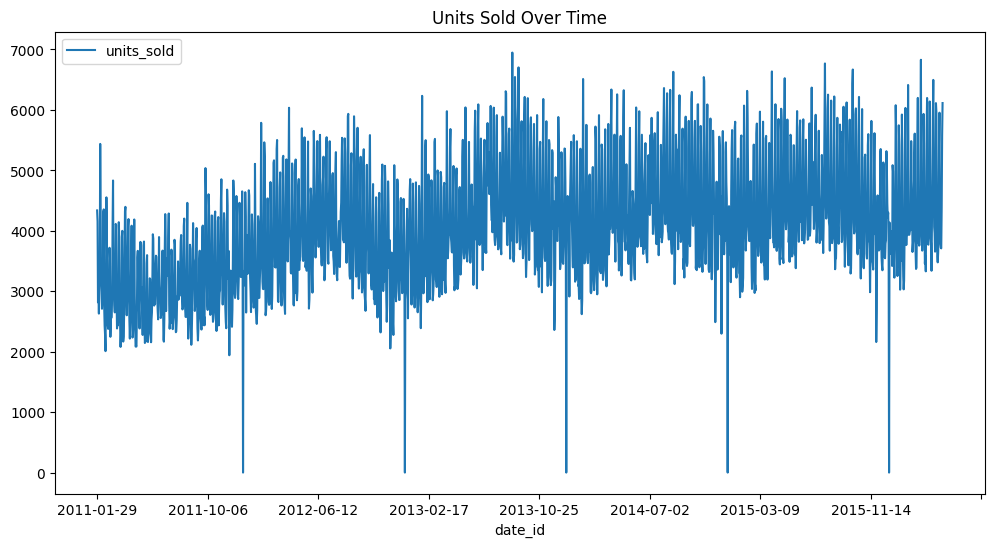

In [9]:
data_daily.plot(x='date_id', y='units_sold', figsize=(12,6), title='Units Sold Over Time')

In [10]:
data_daily.shape

(1913, 18)

In [15]:
xtrain, xtest = train_test_split(data_daily, test_size=0.2, shuffle=False)
ytrain = xtrain['units_sold']

# Auto ARIMA
# start_p, start_q giúp thuật toán bắt đầu tìm kiếm nhanh hơn
auto_model = pm.auto_arima(ytrain,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action="ignore",)

print(auto_model.summary())

# Lấy order trực tiếp
best_order = auto_model.order

print(f"Best Order found: {best_order}")

# Fit model của statsmodels
model = ARIMA(ytrain, order=best_order)
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1530
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -11520.017
Date:                Tue, 25 Nov 2025   AIC                          23064.034
Time:                        14:43:29   BIC                          23128.022
Sample:                             0   HQIC                         23087.849
                               - 1530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0772      1.979      1.555      0.120      -0.801       6.956
ar.L1          1.1548      0.040     29.192      0.000       1.077       1.232
ar.L2         -1.7113      0.035    -49.596      0.0

In [16]:
# Train model arima với tham số mặc định 1,1,1
model_default = ARIMA(ytrain, order=(1,1,1))
result_default = model_default.fit()

In [53]:
model_fineturn1 = ARIMA(ytrain, order=(7,1,7))
result_fineturn1 = model_fineturn1.fit()

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ ConvergenceWarning in                                                       │
│ c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\st │
│ atsmodels\base\model.py:607                                                 │
│ Maximum Likelihood optimization failed to converge. Check mle_retvals       │
└─────────────────────────────────────────────────────────────────────────────┘


In [60]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Đánh giá mô hình trên tập kiểm tra
ytest = xtest['units_sold']
predictions = result.forecast(steps=len(ytest))
mse = np.mean((predictions - ytest) ** 2)
print(f'Test MSE: {mse}')
#AIC
print(f'AIC: {result.aic}')
#RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
# 1. MAE (Mean Absolute Error) - Sai số tuyệt đối trung bình
# Cho biết trung bình dự báo lệch bao nhiêu đơn vị sản phẩm
mae = mean_absolute_error(ytest, predictions)
print(f'MAE: {mae}')

non_zero_index = ytest != 0
ytest_filtered = ytest[non_zero_index]
predictions_filtered = predictions[non_zero_index]

# Tính MAPE trên dữ liệu đã lọc
mape = np.mean(np.abs((ytest_filtered - predictions_filtered) / ytest_filtered)) * 100
print(f'MAPE (đã lọc giá trị 0): {mape:.2f}%')

# Tính Accuracy
accuracy = 100 - mape
print(f'Model Accuracy: {accuracy:.2f}%')

# 4. R-squared (Hệ số xác định)
# Cho biết mô hình giải thích được bao nhiêu % sự biến thiên của dữ liệu
r2 = r2_score(ytest, predictions)
print(f'R-squared: {r2:.4f}')



Test MSE: 304556.4351806843
AIC: 23062.645160198514
RMSE: 551.8663200274902
MAE: 396.5914865806927
MAPE (đã lọc giá trị 0): 8.65%
Model Accuracy: 91.35%
R-squared: 0.6320


In [20]:
# Đánh giá mô hình trên tập kiểm tra
ytest = xtest['units_sold']
predictions_default = result_default.forecast(steps=len(ytest))
mse = np.mean((predictions_default - ytest) ** 2)
print(f'Test MSE: {mse}')
#AIC
print(f'AIC: {result_default.aic}')
#RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Test MSE: 851142.1956139498
AIC: 24575.82480791534
RMSE: 922.5736803171602


In [54]:
# Đánh giá mô hình trên tập kiểm tra
ytest = xtest['units_sold']
predictions_fineturn1 = result_fineturn1.forecast(steps=len(ytest))
mse = np.mean((predictions_fineturn1 - ytest) ** 2)
print(f'Test MSE: {mse}')
#AIC
print(f'AIC: {result_fineturn1.aic}')
#RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Test MSE: 298657.66259857634
AIC: 22945.316210597164
RMSE: 546.4958029103026


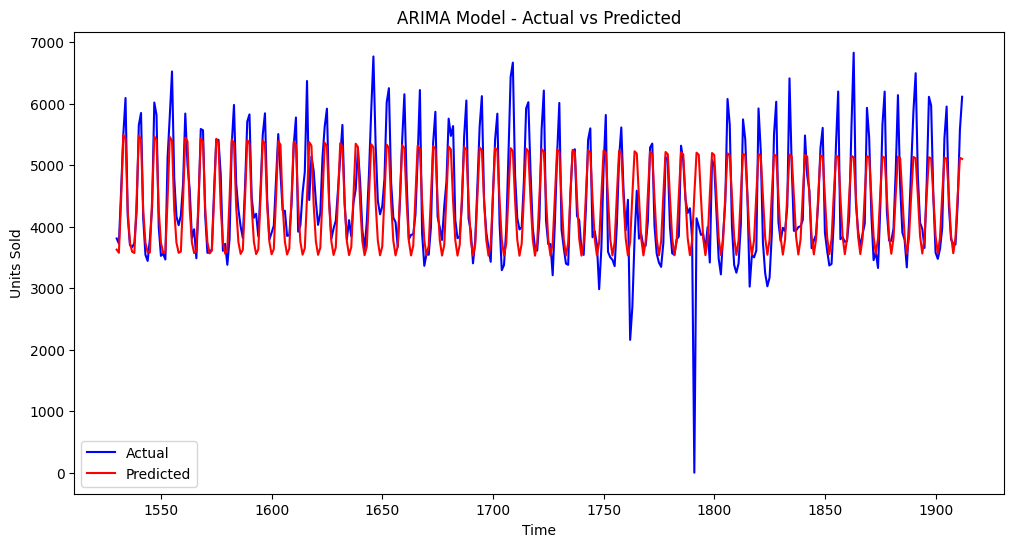

In [55]:
plt.figure(figsize=(12,6))
plt.plot(ytest.index, ytest, label='Actual', color='blue')
plt.plot(ytest.index, predictions_fineturn1, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.title('ARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

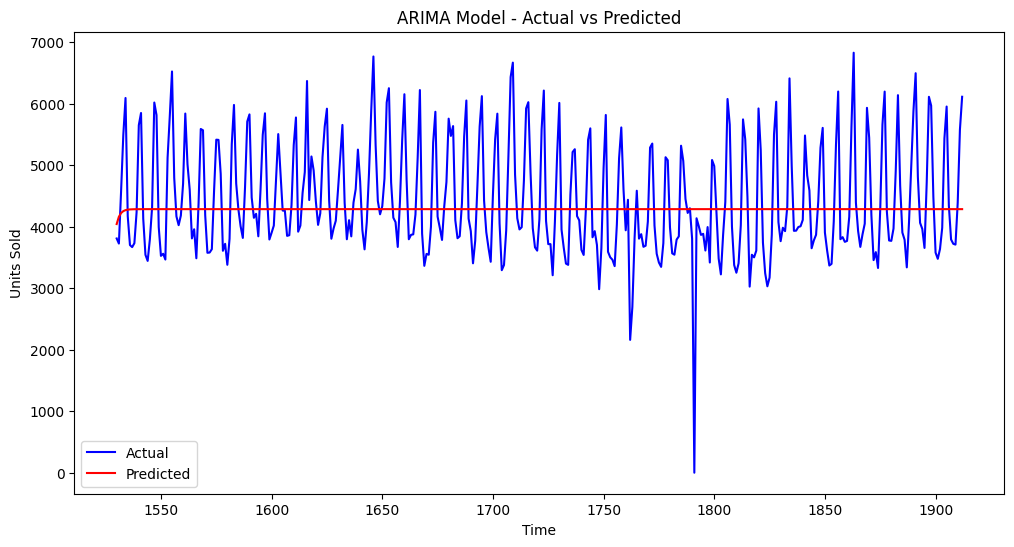

In [22]:
plt.figure(figsize=(12,6))
plt.plot(ytest.index, ytest, label='Actual', color='blue')
plt.plot(ytest.index, predictions_default, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.title('ARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

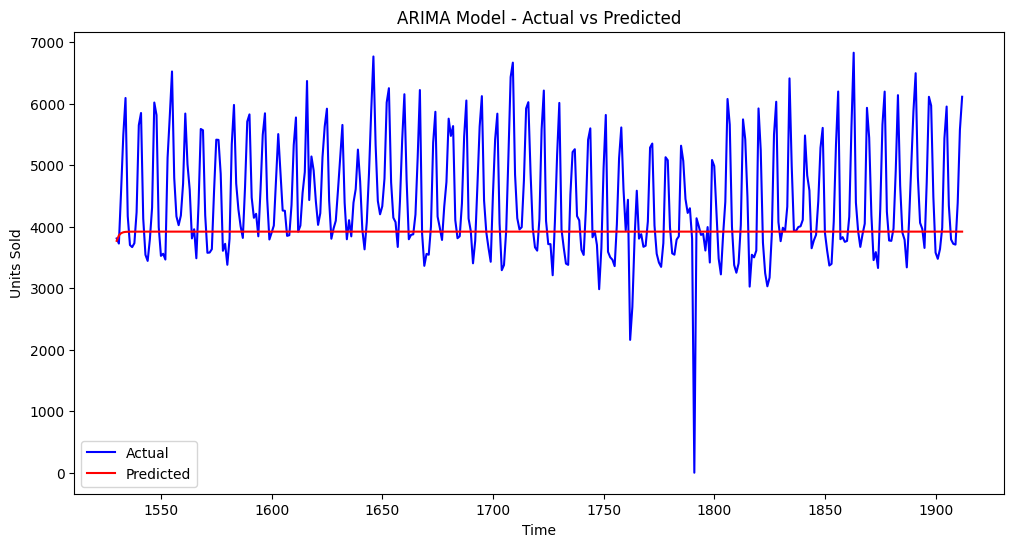

In [ ]:
# vẽ biểu đồ đường thực tế và dự đoán
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(ytest.index, ytest, label='Actual', color='blue')
plt.plot(ytest.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.title('ARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

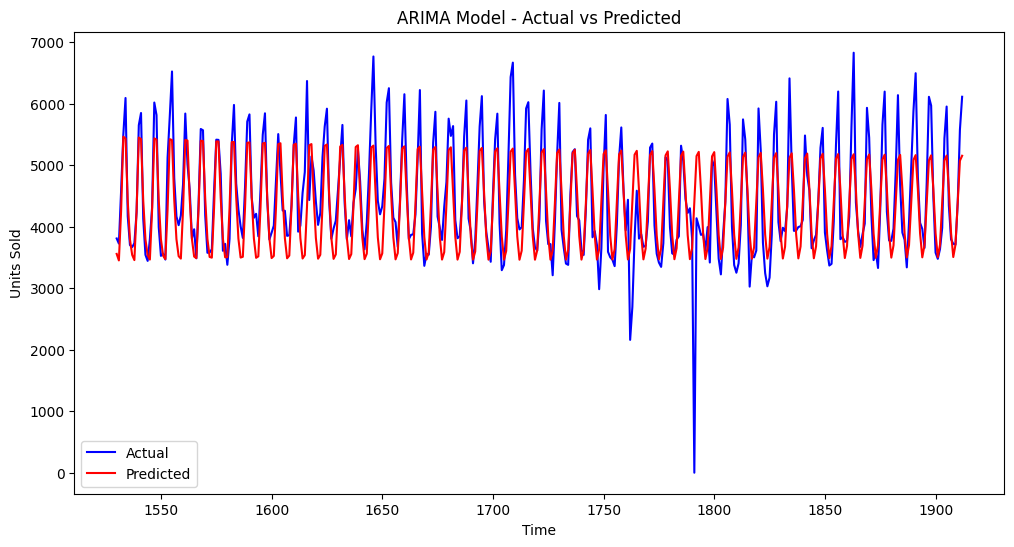

In [49]:
# vẽ biểu đồ đường thực tế và dự đoán
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(ytest.index, ytest, label='Actual', color='blue')
plt.plot(ytest.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.title('ARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
# Kiểm tra white noise residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = result.resid
ljung_box_result = acorr_ljungbox(residuals, lags=[10],                                   return_df=True)
print(ljung_box_result)

      lb_stat  lb_pvalue
10  42.282584   0.000007


In [ ]:

xtrain, xtest = train_test_split(data_daily, test_size=0.2, shuffle=False)
ytrain = xtrain['units_sold']

# Log Transform để ổn định phương sai và tránh số âm
y_log_train = np.log1p(ytrain)

model = pm.auto_arima(y_log_train,
                      start_p=1, start_q=1,
                      max_p=10, max_q=10,
                      m=7,
                      seasonal=True,
                      d=None,
                      test='adf',
                      )

print(model.summary())

preds_log = model.predict(n_periods=len(xtest))

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1530
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood                -957.075
Date:                                Tue, 25 Nov 2025   AIC                           1934.151
Time:                                        15:49:04   BIC                           1987.481
Sample:                                             0   HQIC                          1953.998
                                               - 1530                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0279    141.600      0.021      0.983    -274.503     280.559
ar.

In [62]:
# 4. Đảo ngược Log (Inverse Transform) để về số lượng bán thực
preds = np.expm1(preds_log)

# 5. Đánh giá và Vẽ biểu đồ
rmse = np.sqrt(mean_squared_error(xtest['units_sold'], preds))
print(f"RMSE trên tập Test: {rmse}")

RMSE trên tập Test: 585.4269390679618


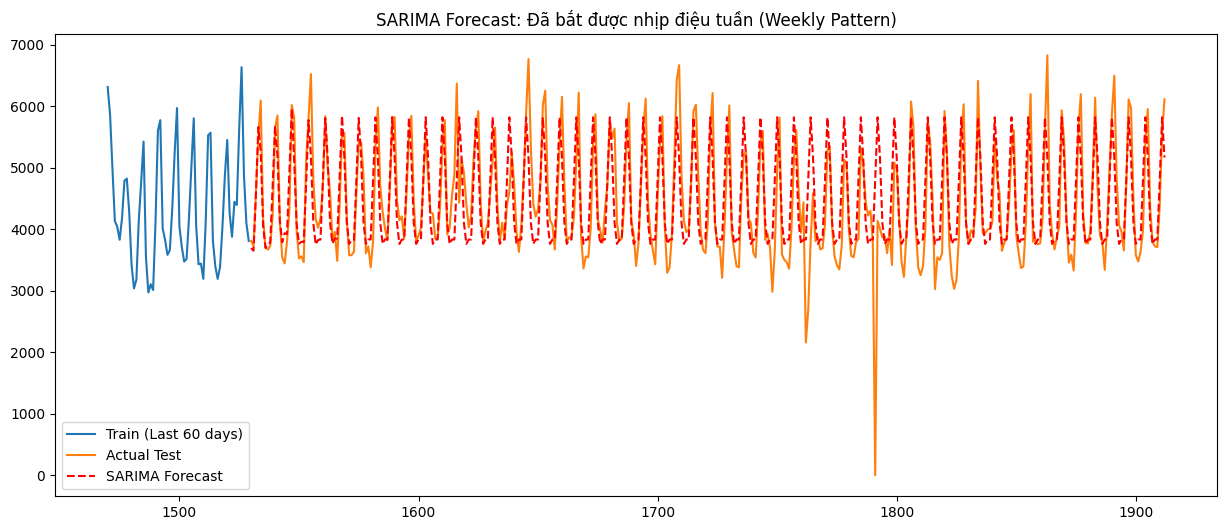

In [63]:
plt.figure(figsize=(15, 6))
# Vẽ 60 ngày cuối của train để thấy sự nối tiếp
plt.plot(ytrain.index[-60:], ytrain.values[-60:], label='Train (Last 60 days)')
plt.plot(xtest.index, xtest['units_sold'], label='Actual Test')
plt.plot(xtest.index, preds, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('SARIMA Forecast: Đã bắt được nhịp điệu tuần (Weekly Pattern)')
plt.legend()
plt.show()

In [ ]:
# Kiểm tra white noise residuals
residuals = model.resid()
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=[10],                                   return_df=True)
print(ljung_box_result)# Kiểm tra white noise residuals

        lb_stat  lb_pvalue
10  2674.655325        0.0


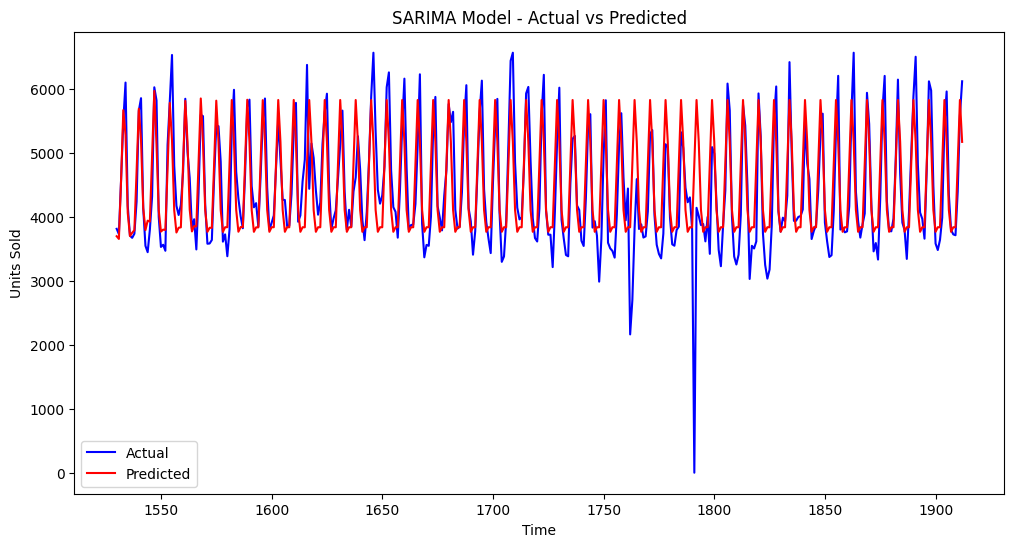

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(xtest.index, xtest['units_sold'], label='Actual', color='blue')

plt.plot(xtest.index, preds, label='Predicted', color='red')

plt.xlabel('Time')

plt.ylabel('Units Sold')

plt.title('SARIMA Model - Actual vs Predicted')

plt.legend()

plt.show()

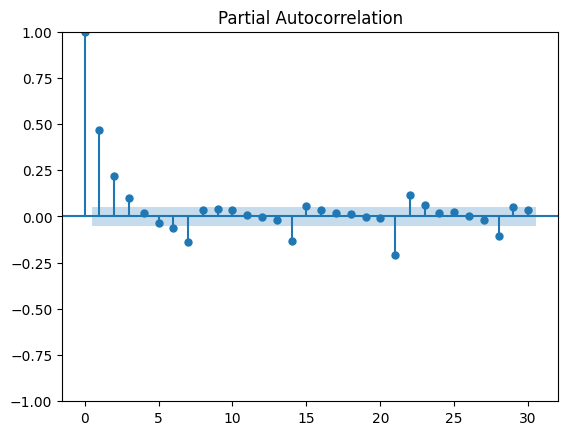

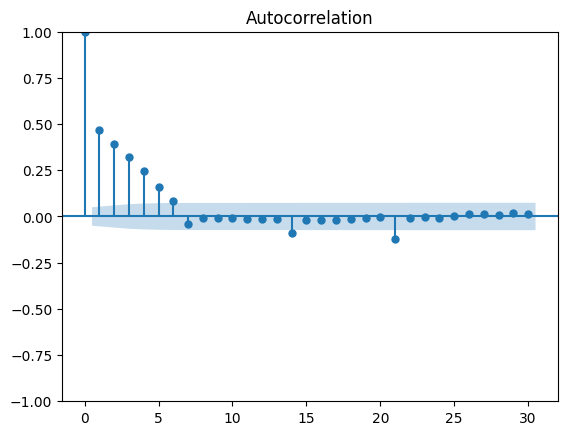

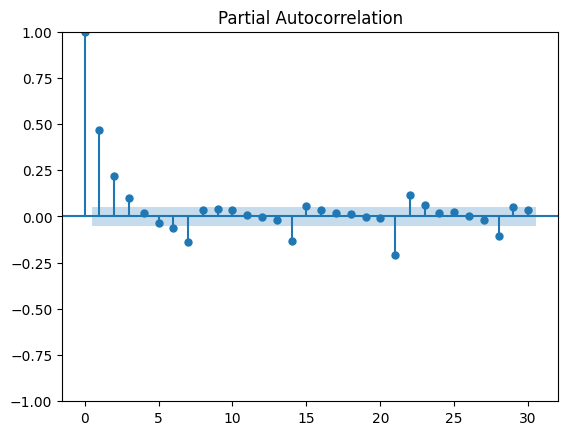

In [ ]:
# Biểu đồ ACF/PACFcủa phàn dữ
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
